In [12]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [13]:
import scipy
from numpy import exp
from matplotlib import pyplot as plt
import numpy as np
import cv2
import pandas as pd
from math import pi, sqrt
import pywt
import os
from sklearn.metrics import accuracy_score

In [14]:
def discrete_wave_transform(image):
    coeffs = pywt.dwt2(image, 'haar')
    cA, (cH, cV, cD) = coeffs
    return cA

def gaussian_matched_filter_kernel(L, sigma, t = 3, mf = True):
    '''
    K =  1/(sqrt(2 * pi) * sigma ) * exp(-x^2/2sigma^2), |y| <= L/2, |x| < s * t
    '''
    dim_y = int(L)
    dim_x = 2 * int(t * sigma)
    arr = np.zeros((dim_y, dim_x), 'f')
    
    ctr_x = dim_x / 2 
    ctr_y = int(dim_y / 2.)

    # an un-natural way to set elements of the array
    # to their x coordinate. 
    # x's are actually columns, so the first dimension of the iterator is used
    it = np.nditer(arr, flags=['multi_index'])
    while not it.finished:
        arr[it.multi_index] = it.multi_index[1] - ctr_x
        it.iternext()

    two_sigma_sq = 2 * sigma * sigma
    sqrt_w_pi_sigma = 1. / (sqrt(2 * pi) * sigma)
    if not mf:
        sqrt_w_pi_sigma = sqrt_w_pi_sigma / sigma ** 2

    def k_fun(x):
        return sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    def k_fun_derivative(x):
        return -x * sqrt_w_pi_sigma * exp(-x * x / two_sigma_sq)

    if mf:
        kernel = k_fun(arr)
        kernel = kernel - kernel.mean()
    else:
        kernel = k_fun_derivative(arr)

    # return the "convolution" kernel for filter2D
    return cv2.flip(kernel, -1)

#Creating a matched filter bank using the kernel generated from the above functions
def createMatchedFilterBank(K, n = 12):
    rotate = 180 / n
    center = (K.shape[1] / 2, K.shape[0] / 2)
    cur_rot = 0
    kernels = [K]
    filters = []
    ksize = 31
    
    for i in range(1, n):
        cur_rot += rotate
        r_mat = cv2.getRotationMatrix2D(center, cur_rot, 1)
        k = cv2.warpAffine(K, r_mat, (K.shape[1], K.shape[0]))
        kernels.append(k)

    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 6, theta,12, 0.37, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)

    return kernels,filters

#Given a filter bank, apply them and record maximum response
def applyFilters(im, kernels):

    images = np.array([cv2.filter2D(im, -1, k) for k in kernels])
    return np.max(images, 0)

def kmeans_color_quantization(image):
    img = image.reshape((576, 750))
    Z = img.reshape((-1,3))

    # convert to np.float32
    Z = np.float32(Z)

    k=cv2.KMEANS_PP_CENTERS


    # define criteria, number of clusters(K) and apply kmeans()
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    K = 2
    ret,label,center=cv2.kmeans(Z,K,None,criteria,10,k)

    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    res = center[label.flatten()]
    res2 = res.reshape((img.shape))
    return np.array(res2).flatten()

immatrix=[]

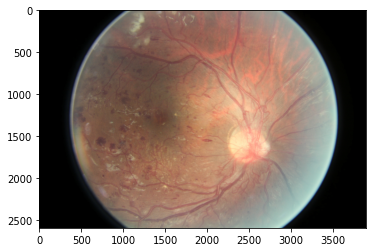

In [15]:
from PIL import Image
im = Image.open(r'/content/drive/MyDrive/16_left.jpeg')
plt.imshow(im)
plt.show()

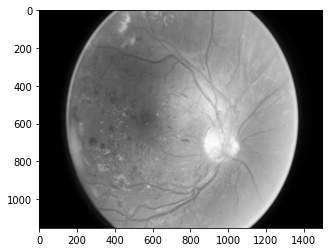

In [16]:
img = cv2.imread(r'/content/drive/MyDrive/16_left.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap='gray')
plt.show()

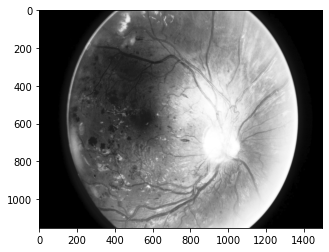

In [17]:
equ = cv2.equalizeHist(img_gray)
plt.imshow(equ,cmap='gray')
plt.show()

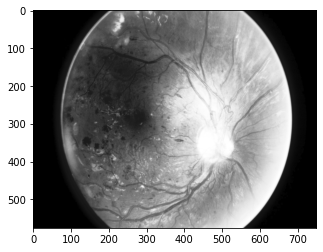

In [18]:
dwt_img = discrete_wave_transform(equ)
plt.imshow(dwt_img,cmap='gray')
plt.show()

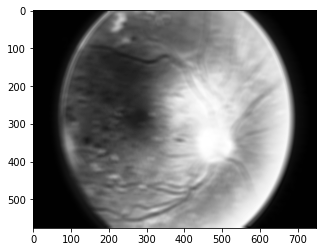

In [19]:
kernel = gaussian_matched_filter_kernel(20, 5)
kernels,filters = createMatchedFilterBank(kernel, 4)

equ3 = applyFilters(dwt_img,kernels)
plt.imshow(equ3,cmap='gray')
plt.show()

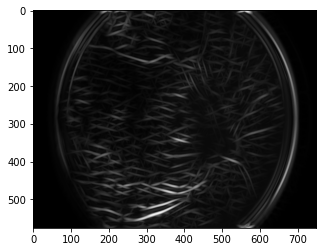

In [20]:
equ4 = applyFilters(equ3,filters)
plt.imshow(equ4,cmap='gray')
plt.show()

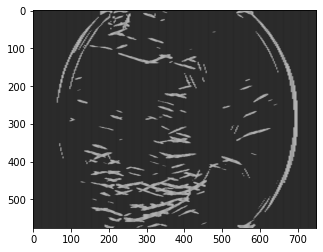

In [21]:
kmeans_img = kmeans_color_quantization(equ4)
immatrix.append(kmeans_img)
plt.imshow(kmeans_img.reshape((576, 750)),cmap='gray')
plt.show()